### Import library and model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

### Import, Scale and Split Dataset

In [2]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('..\Dataset\EUR.csv')
 # GBP - VND
gbp = pd.read_csv("..\Dataset\GBP.csv")
 # JPY - VND
jpy = pd.read_csv("..\Dataset\JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

### MinMaxScaler

In [3]:
# Scaler model
scaler=MinMaxScaler(feature_range=(0,1))

### Standardizate function

In [4]:
# Function to standardizate the data
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

### Prepare data

In [5]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

### Forecast

In [6]:
# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test):
    x_input = test[len(test)-100:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    n_steps=100
    i=0
    while(i<=90):
        if(len(temp_input)>100):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1,-1)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i=i+1
        else:
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i=i+1
    return forecast30, forecast60, forecast90

### Visualize

In [7]:
# Function to visualize the model
def visualize_RNN(model, train, test, pre_test, f3, f6, f9):
    # set index
    # set train, test index
    index = pd.date_range(start='3/1/2019', end='6/1/2024', freq='d')
    # set forecast index
    forecast_index = pd.date_range(start='6/1/2024', periods=91, freq='d')
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(index[:len(train)], scaler.inverse_transform(train))
    plt.plot(index[len(train):], scaler.inverse_transform(test))
    plt.plot(index[len(train)+100:],scaler.inverse_transform(pre_test))
    plt.plot(forecast_index[:31], scaler.inverse_transform(f3))
    plt.plot(forecast_index[31:61], scaler.inverse_transform(f6))
    plt.plot(forecast_index[61:], scaler.inverse_transform(f9))
    plt.title('MLP Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','TestPred','Forecast 30 days next','Forecast 60 days next','Forecast 90 days next'])
    plt.show()

### Evaluate

In [8]:
# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE(%) =',mape)
    print('MAE =',mae)

### Implement

In [9]:
def implement_MLP(train, test):
    n_steps = 100
    
    # Convert train and test data
    X_train, y_train = create_dataset(train, n_steps)
    X_test, y_test = create_dataset(test, n_steps)
    
    # Define MLP model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_steps))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit model
    model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=0)
    
    # Predict test data
    pre_test = model.predict(X_test)
    
    # Forecast next 30, 60, 90 days
    forecast30, forecast60, forecast90 = forecast_days(model, test)
    
    # Visualize model
    visualize_RNN(model, train, test, pre_test, forecast30, forecast60, forecast90)

    # Standardizate
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accurancy
    evaluate(pre_test, test[100:])

# EUR - VND


In [10]:
# Scale data
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
 ## case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
 ## case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.8873519]
101
1 day input [0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.69966354 0.69966354 0.72126793 0.72551797 0.73685143
 0.7467682  0.75491411 0.75491411 0.75491411 0.75615371 0.74924739
 0.75721622 0.76553922 0.74765362 0.74765362 0.74765362 0.74995573
 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638  0.7251638
 0.72374712 0.74039313 0.73614308 0.71506995 0.7180804  0.7180804
 0.7180804  0.71985125 0.71949708 0.74765362 0.78289357 0.77226846
 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555
 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846
 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.8689569

8 day output [[1.013422]]
9 day input [0.69966354 0.72126793 0.72551797 0.73685143 0.7467682  0.75491411
 0.75491411 0.75491411 0.75615371 0.74924739 0.75721622 0.76553922
 0.74765362 0.74765362 0.74765362 0.74995573 0.73667434 0.74499734
 0.76571631 0.7251638  0.7251638  0.7251638  0.72374712 0.74039313
 0.73614308 0.71506995 0.7180804  0.7180804  0.7180804  0.71985125
 0.71949708 0.74765362 0.78289357 0.77226846 0.77226846 0.77226846
 0.76536214 0.78006021 0.78006021 0.73295555 0.71135116 0.71135116
 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312
 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707
 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411 0.77032052
 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814
 0.82380025 0.82450859 0.839915   0.839915   0.839915   0.83832123
 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0

18 day output [[1.1755844]]
19 day input [0.75721622 0.76553922 0.74765362 0.74765362 0.74765362 0.74995573
 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638  0.7251638
 0.72374712 0.74039313 0.73614308 0.71506995 0.7180804  0.7180804
 0.7180804  0.71985125 0.71949708 0.74765362 0.78289357 0.77226846
 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555
 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846
 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.88735187 0.90409195 0.91923708
 0.9320879  0.94635051 0.

28 day output [[1.3422636]]
29 day input [0.7251638  0.7251638  0.72374712 0.74039313 0.73614308 0.71506995
 0.7180804  0.7180804  0.7180804  0.71985125 0.71949708 0.74765362
 0.78289357 0.77226846 0.77226846 0.77226846 0.76536214 0.78006021
 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474
 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312
 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042
 0.8029042  0.78448734 0.79440411 0.77032052 0.79652913 0.81565433
 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859
 0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.88735187
 0.90409195 0.91923708 0.9320879  0.94635051 0.96155435 0.98349392
 0.98242831 1.01342201 1.03234613 1.04373991 1.07971466 1.09308183
 1.09945083 1.13259709

38 day output [[1.4863297]]
39 day input [0.71949708 0.74765362 0.78289357 0.77226846 0.77226846 0.77226846
 0.76536214 0.78006021 0.78006021 0.73295555 0.71135116 0.71135116
 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312
 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707
 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411 0.77032052
 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814
 0.82380025 0.82450859 0.839915   0.839915   0.839915   0.83832123
 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.88735187 0.90409195 0.91923708 0.9320879  0.94635051
 0.96155435 0.98349392 0.98242831 1.01342201 1.03234613 1.04373991
 1.07971466 1.09308183 1.09945083 1.13259709 1.14219046 1.15205657
 1.1678561  1.17558444 1.198686   1.2209537  1.22827065 1.25046766
 1.25664043 1.2650636

47 day output [[1.5676963]]
48 day input [0.73295555 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107
 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734
 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042
 0.78448734 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818
 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.88735187 0.90409195
 0.91923708 0.9320879  0.94635051 0.96155435 0.98349392 0.98242831
 1.01342201 1.03234613 1.04373991 1.07971466 1.09308183 1.09945083
 1.13259709 1.14219046 1.15205657 1.1678561  1.17558444 1.198686
 1.2209537  1.22827065 1.25046766 1.25664043 1.26506364 1.29237282
 1.30989718 1.32265401 1.34226358 1.3568275  1.37308037 1.38773227
 1.40568066 1.43171751 1.4

57 day output [[1.6380758]]
58 day input [0.77988312 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042
 0.8029042  0.8029042  0.78448734 0.79440411 0.77032052 0.79652913
 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.88735187 0.90409195 0.91923708 0.9320879  0.94635051 0.96155435
 0.98349392 0.98242831 1.01342201 1.03234613 1.04373991 1.07971466
 1.09308183 1.09945083 1.13259709 1.14219046 1.15205657 1.1678561
 1.17558444 1.198686   1.2209537  1.22827065 1.25046766 1.25664043
 1.26506364 1.29237282 1.30989718 1.32265401 1.34226358 1.3568275
 1.37308037 1.38773227 1.40568066 1.43171751 1.45143807 1.46222281
 1.47387421 1.48274124 1.48632967 1.51524544 1.52660131 1.53076112
 1.53546107 1.54689848 1

66 day output [[1.7705525]]
67 day input [0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.88735187 0.90409195 0.91923708
 0.9320879  0.94635051 0.96155435 0.98349392 0.98242831 1.01342201
 1.03234613 1.04373991 1.07971466 1.09308183 1.09945083 1.13259709
 1.14219046 1.15205657 1.1678561  1.17558444 1.198686   1.2209537
 1.22827065 1.25046766 1.25664043 1.26506364 1.29237282 1.30989718
 1.32265401 1.34226358 1.3568275  1.37308037 1.38773227 1.40568066
 1.43171751 1.45143807 1.46222281 1.47387421 1.48274124 1.48632967
 1.51524544 1.52660131 1.53076112 1.53546107 1.54689848 1.55522037
 1.56838381 1.56648052 1.56769633 1.56721354 1.56466007 1.57952511
 1.59132051 1.59789681 1

76 day output [[1.979849]]
77 day input [0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.88735187
 0.90409195 0.91923708 0.9320879  0.94635051 0.96155435 0.98349392
 0.98242831 1.01342201 1.03234613 1.04373991 1.07971466 1.09308183
 1.09945083 1.13259709 1.14219046 1.15205657 1.1678561  1.17558444
 1.198686   1.2209537  1.22827065 1.25046766 1.25664043 1.26506364
 1.29237282 1.30989718 1.32265401 1.34226358 1.3568275  1.37308037
 1.38773227 1.40568066 1.43171751 1.45143807 1.46222281 1.47387421
 1.48274124 1.48632967 1.51524544 1.52660131 1.53076112 1.53546107
 1.54689848 1.55522037 1.56838381 1.56648052 1.56769633 1.56721354
 1.56466007 1.57952511 1.59132051 1.59789681 1.60855281 1.60897803
 1.61887145 1.62967002 1.63807583 1.65809429 1.66995835 1.68582487
 1.70614898 1.70776129

86 day output [[2.1776912]]
87 day input [0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.88735187 0.90409195 0.91923708 0.9320879  0.94635051
 0.96155435 0.98349392 0.98242831 1.01342201 1.03234613 1.04373991
 1.07971466 1.09308183 1.09945083 1.13259709 1.14219046 1.15205657
 1.1678561  1.17558444 1.198686   1.2209537  1.22827065 1.25046766
 1.25664043 1.26506364 1.29237282 1.30989718 1.32265401 1.34226358
 1.3568275  1.37308037 1.38773227 1.40568066 1.43171751 1.45143807
 1.46222281 1.47387421 1.48274124 1.48632967 1.51524544 1.52660131
 1.53076112 1.53546107 1.54689848 1.55522037 1.56838381 1.56648052
 1.56769633 1.56721354 1.56466007 1.57952511 1.59132051 1.59789681
 1.60855281 1.60897803 1.61887145 1.62967002 1.63807583 1.65809429
 1.66995835 1.68582487 1.70614898 1.70776129 1.72235036 1.73549783
 1.75405693 1.77055252 1.78313303 1.80474222 1.81883669 1.83599794
 1.86403453 1.8851288

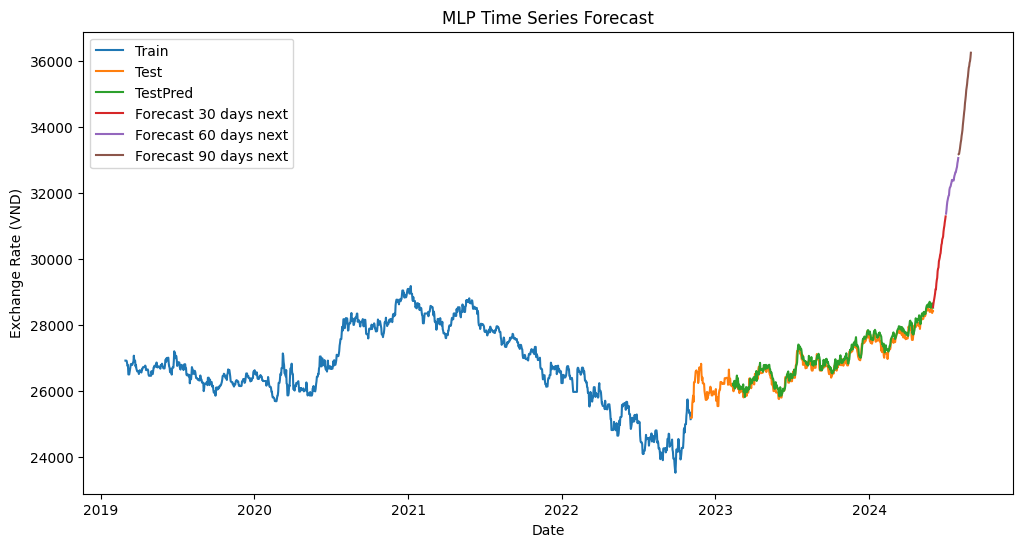

RMSE = 150.10563295339426
MAPE(%) = 0.4592046884189887
MAE = 123.90059578518914


In [11]:
implement_MLP(train_eur_1_sc, test_eur_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.8550094]
101
1 day input [0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.69966354 0.69966354 0.72126793 0.72551797 0.73685143
 0.7467682  0.75491411 0.75491411 0.75491411 0.75615371 0.74924739
 0.75721622 0.76553922 0.74765362 0.74765362 0.74765362 0.74995573
 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638  0.7251638
 0.72374712 0.74039313 0.73614308 0.71506995 0.7180804  0.7180804
 0.7180804  0.71985125 0.71949708 0.74765362 0.78289357 0.77226846
 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555
 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846
 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697


9 day output [[0.8206011]]
10 day input [0.72126793 0.72551797 0.73685143 0.7467682  0.75491411 0.75491411
 0.75491411 0.75615371 0.74924739 0.75721622 0.76553922 0.74765362
 0.74765362 0.74765362 0.74995573 0.73667434 0.74499734 0.76571631
 0.7251638  0.7251638  0.7251638  0.72374712 0.74039313 0.73614308
 0.71506995 0.7180804  0.7180804  0.7180804  0.71985125 0.71949708
 0.74765362 0.78289357 0.77226846 0.77226846 0.77226846 0.76536214
 0.78006021 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116
 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312
 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042
 0.8029042  0.8029042  0.78448734 0.79440411 0.77032052 0.79652913
 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 

17 day output [[0.7891128]]
18 day input [0.74924739 0.75721622 0.76553922 0.74765362 0.74765362 0.74765362
 0.74995573 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638
 0.7251638  0.72374712 0.74039313 0.73614308 0.71506995 0.7180804
 0.7180804  0.7180804  0.71985125 0.71949708 0.74765362 0.78289357
 0.77226846 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021
 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107
 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734
 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042
 0.78448734 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818
 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.85500938 0.85136747
 0.86013108 0.85818583 0.8

27 day output [[0.7468042]]
28 day input [0.7251638  0.7251638  0.7251638  0.72374712 0.74039313 0.73614308
 0.71506995 0.7180804  0.7180804  0.7180804  0.71985125 0.71949708
 0.74765362 0.78289357 0.77226846 0.77226846 0.77226846 0.76536214
 0.78006021 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116
 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312
 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042
 0.8029042  0.8029042  0.78448734 0.79440411 0.77032052 0.79652913
 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.85500938 0.85136747 0.86013108 0.85818583 0.85137177 0.84427309
 0.82407624 0.82418287 0.81437999 0.82060111 0.82211012 0.81737894
 0.81416887 0.80432683

37 day output [[0.72405124]]
38 day input [0.71985125 0.71949708 0.74765362 0.78289357 0.77226846 0.77226846
 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555 0.71135116
 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698
 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989
 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.85500938 0.85136747 0.86013108 0.85818583
 0.85137177 0.84427309 0.82407624 0.82418287 0.81437999 0.82060111
 0.82211012 0.81737894 0.81416887 0.80432683 0.79793787 0.7977404
 0.78896546 0.78911281 0.77781272 0.77285904 0.77898991 0.7734201
 0.76285517 0.76054233 0

46 day output [[0.6961603]]
47 day input [0.78006021 0.73295555 0.71135116 0.71135116 0.71135116 0.73543474
 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312 0.77988312
 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042
 0.8029042  0.78448734 0.79440411 0.77032052 0.79652913 0.81565433
 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859
 0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.85500938
 0.85136747 0.86013108 0.85818583 0.85137177 0.84427309 0.82407624
 0.82418287 0.81437999 0.82060111 0.82211012 0.81737894 0.81416887
 0.80432683 0.79793787 0.7977404  0.78896546 0.78911281 0.77781272
 0.77285904 0.77898991 0.7734201  0.76285517 0.76054233 0.7595889
 0.75390553 0.74756968 0.74680418 0.74262553 0.74629879 0.74510175
 0.74183714 0.74013853 

56 day output [[0.6602822]]
57 day input [0.77988312 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707
 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411 0.77032052
 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814
 0.82380025 0.82450859 0.839915   0.839915   0.839915   0.83832123
 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.85500938 0.85136747 0.86013108 0.85818583 0.85137177
 0.84427309 0.82407624 0.82418287 0.81437999 0.82060111 0.82211012
 0.81737894 0.81416887 0.80432683 0.79793787 0.7977404  0.78896546
 0.78911281 0.77781272 0.77285904 0.77898991 0.7734201  0.76285517
 0.76054233 0.7595889  0.75390553 0.74756968 0.74680418 0.74262553
 0.74629879 0.74510175 0.74183714 0.74013853 0.73092705 0.72759527
 0.72888154 0.71585578 0.72405124 0.72091174 0.71673089 0.70820057
 0.69330513 0.7004269

66 day output [[0.632715]]
67 day input [0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.85500938 0.85136747 0.86013108
 0.85818583 0.85137177 0.84427309 0.82407624 0.82418287 0.81437999
 0.82060111 0.82211012 0.81737894 0.81416887 0.80432683 0.79793787
 0.7977404  0.78896546 0.78911281 0.77781272 0.77285904 0.77898991
 0.7734201  0.76285517 0.76054233 0.7595889  0.75390553 0.74756968
 0.74680418 0.74262553 0.74629879 0.74510175 0.74183714 0.74013853
 0.73092705 0.72759527 0.72888154 0.71585578 0.72405124 0.72091174
 0.71673089 0.70820057 0.69330513 0.70042694 0.70387131 0.7033236
 0.70242941 0.69616032 0.69054282 0.68423188 0.68095839 0.67853665
 0.67705864 0.67840904 0.

76 day output [[0.6035909]]
77 day input [0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.85500938
 0.85136747 0.86013108 0.85818583 0.85137177 0.84427309 0.82407624
 0.82418287 0.81437999 0.82060111 0.82211012 0.81737894 0.81416887
 0.80432683 0.79793787 0.7977404  0.78896546 0.78911281 0.77781272
 0.77285904 0.77898991 0.7734201  0.76285517 0.76054233 0.7595889
 0.75390553 0.74756968 0.74680418 0.74262553 0.74629879 0.74510175
 0.74183714 0.74013853 0.73092705 0.72759527 0.72888154 0.71585578
 0.72405124 0.72091174 0.71673089 0.70820057 0.69330513 0.70042694
 0.70387131 0.7033236  0.70242941 0.69616032 0.69054282 0.68423188
 0.68095839 0.67853665 0.67705864 0.67840904 0.68003285 0.68119711
 0.67529947 0.66028219 0.6596877  0.65082878 0.65463841 0.6563217
 0.65599537 0.65415233 

85 day output [[0.58430535]]
86 day input [0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.85500938 0.85136747 0.86013108 0.85818583
 0.85137177 0.84427309 0.82407624 0.82418287 0.81437999 0.82060111
 0.82211012 0.81737894 0.81416887 0.80432683 0.79793787 0.7977404
 0.78896546 0.78911281 0.77781272 0.77285904 0.77898991 0.7734201
 0.76285517 0.76054233 0.7595889  0.75390553 0.74756968 0.74680418
 0.74262553 0.74629879 0.74510175 0.74183714 0.74013853 0.73092705
 0.72759527 0.72888154 0.71585578 0.72405124 0.72091174 0.71673089
 0.70820057 0.69330513 0.70042694 0.70387131 0.7033236  0.70242941
 0.69616032 0.69054282 0.68423188 0.68095839 0.67853665 0.67705864
 0.67840904 0.68003285 0.68119711 0.67529947 0.66028219 0.6596877
 0.65082878 0.65463841 0.6563217  0.65599537 0.65415233 0.64630514
 0.63747078 0.63586062 0.63271499 0.63308287 0.62812543 0.62453455
 0.6311844  0.62688237 

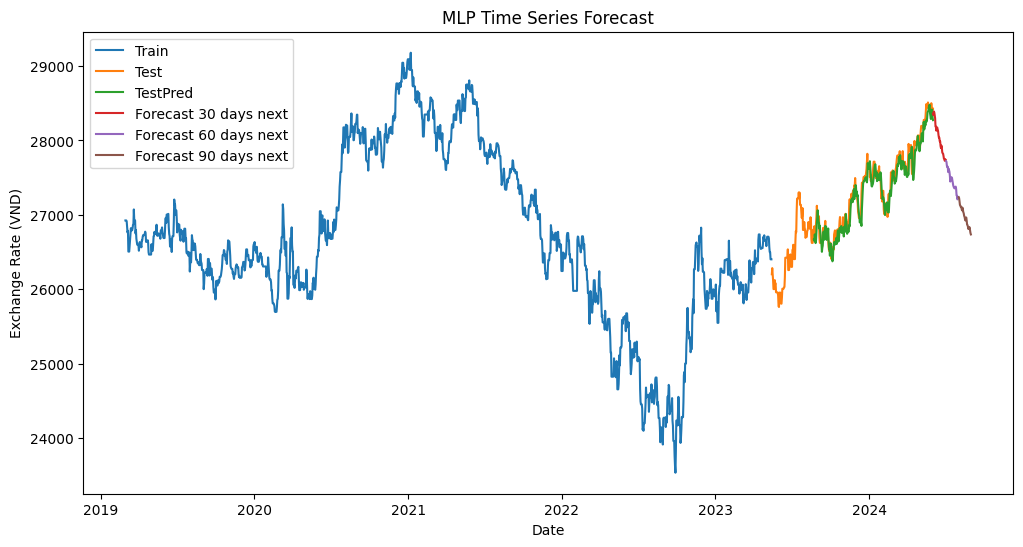

RMSE = 128.0500826626721
MAPE(%) = 0.36578618151307196
MAE = 100.31846941021135


In [12]:
implement_MLP(train_eur_2_sc, test_eur_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[0.8445617]
101
1 day input [0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.69966354 0.69966354 0.72126793 0.72551797 0.73685143
 0.7467682  0.75491411 0.75491411 0.75491411 0.75615371 0.74924739
 0.75721622 0.76553922 0.74765362 0.74765362 0.74765362 0.74995573
 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638  0.7251638
 0.72374712 0.74039313 0.73614308 0.71506995 0.7180804  0.7180804
 0.7180804  0.71985125 0.71949708 0.74765362 0.78289357 0.77226846
 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555
 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846
 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697


8 day output [[0.78993434]]
9 day input [0.69966354 0.72126793 0.72551797 0.73685143 0.7467682  0.75491411
 0.75491411 0.75491411 0.75615371 0.74924739 0.75721622 0.76553922
 0.74765362 0.74765362 0.74765362 0.74995573 0.73667434 0.74499734
 0.76571631 0.7251638  0.7251638  0.7251638  0.72374712 0.74039313
 0.73614308 0.71506995 0.7180804  0.7180804  0.7180804  0.71985125
 0.71949708 0.74765362 0.78289357 0.77226846 0.77226846 0.77226846
 0.76536214 0.78006021 0.78006021 0.73295555 0.71135116 0.71135116
 0.71135116 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312
 0.77988312 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707
 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411 0.77032052
 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814
 0.82380025 0.82450859 0.839915   0.839915   0.839915   0.83832123
 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576

18 day output [[0.69989616]]
19 day input [0.75721622 0.76553922 0.74765362 0.74765362 0.74765362 0.74995573
 0.73667434 0.74499734 0.76571631 0.7251638  0.7251638  0.7251638
 0.72374712 0.74039313 0.73614308 0.71506995 0.7180804  0.7180804
 0.7180804  0.71985125 0.71949708 0.74765362 0.78289357 0.77226846
 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555
 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846
 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.8445617  0.83760566 0.83583444
 0.81915265 0.80951554 0

27 day output [[0.59138167]]
28 day input [0.7251638  0.7251638  0.7251638  0.72374712 0.74039313 0.73614308
 0.71506995 0.7180804  0.7180804  0.7180804  0.71985125 0.71949708
 0.74765362 0.78289357 0.77226846 0.77226846 0.77226846 0.76536214
 0.78006021 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116
 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312
 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042
 0.8029042  0.8029042  0.78448734 0.79440411 0.77032052 0.79652913
 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.8445617  0.83760566 0.83583444 0.81915265 0.80951554 0.80980927
 0.80497068 0.79383862 0.78993434 0.78264207 0.77909833 0.76462656
 0.75525272 0.7544103

36 day output [[0.54939693]]
37 day input [0.7180804  0.71985125 0.71949708 0.74765362 0.78289357 0.77226846
 0.77226846 0.77226846 0.76536214 0.78006021 0.78006021 0.73295555
 0.71135116 0.71135116 0.71135116 0.73543474 0.74234107 0.77226846
 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734 0.78661236
 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.8445617  0.83760566 0.83583444
 0.81915265 0.80951554 0.80980927 0.80497068 0.79383862 0.78993434
 0.78264207 0.77909833 0.76462656 0.75525272 0.75441039 0.73245913
 0.72345978 0.71523523 0.69887239 0.69989616 0.67451221 0.6678651
 0.65699124 0.63948959 

45 day output [[0.5466758]]
46 day input [0.78006021 0.78006021 0.73295555 0.71135116 0.71135116 0.71135116
 0.73543474 0.74234107 0.77226846 0.78997698 0.77988312 0.77988312
 0.77988312 0.78448734 0.78661236 0.78979989 0.79847707 0.8029042
 0.8029042  0.8029042  0.78448734 0.79440411 0.77032052 0.79652913
 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.8445617  0.83760566 0.83583444 0.81915265 0.80951554 0.80980927
 0.80497068 0.79383862 0.78993434 0.78264207 0.77909833 0.76462656
 0.75525272 0.75441039 0.73245913 0.72345978 0.71523523 0.69887239
 0.69989616 0.67451221 0.6678651  0.65699124 0.63948959 0.63079703
 0.61834902 0.6155591  0.60743523 0.59138167 0.59057128 0.57901132
 0.57083797 0.55638075

53 day output [[0.5391771]]
54 day input [0.77226846 0.78997698 0.77988312 0.77988312 0.77988312 0.78448734
 0.78661236 0.78979989 0.79847707 0.8029042  0.8029042  0.8029042
 0.78448734 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818
 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859 0.839915
 0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.8445617  0.83760566
 0.83583444 0.81915265 0.80951554 0.80980927 0.80497068 0.79383862
 0.78993434 0.78264207 0.77909833 0.76462656 0.75525272 0.75441039
 0.73245913 0.72345978 0.71523523 0.69887239 0.69989616 0.67451221
 0.6678651  0.65699124 0.63948959 0.63079703 0.61834902 0.6155591
 0.60743523 0.59138167 0.59057128 0.57901132 0.57083797 0.55638075
 0.56019872 0.55731744 0.55733794 0.56192619 0.54939693 0.54585129
 0.54395831 0.54337496 0.

63 day output [[0.48425066]]
64 day input [0.8029042  0.8029042  0.78448734 0.79440411 0.77032052 0.79652913
 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.8445617  0.83760566 0.83583444 0.81915265 0.80951554 0.80980927
 0.80497068 0.79383862 0.78993434 0.78264207 0.77909833 0.76462656
 0.75525272 0.75441039 0.73245913 0.72345978 0.71523523 0.69887239
 0.69989616 0.67451221 0.6678651  0.65699124 0.63948959 0.63079703
 0.61834902 0.6155591  0.60743523 0.59138167 0.59057128 0.57901132
 0.57083797 0.55638075 0.56019872 0.55731744 0.55733794 0.56192619
 0.54939693 0.54585129 0.54395831 0.54337496 0.55909717 0.55015355
 0.56141907 0.55241704 0.54463583 0.5466758  0.54023623 0.5384317
 0.54169434 0.5375841

73 day output [[0.42193866]]
74 day input [0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.8445617  0.83760566 0.83583444 0.81915265
 0.80951554 0.80980927 0.80497068 0.79383862 0.78993434 0.78264207
 0.77909833 0.76462656 0.75525272 0.75441039 0.73245913 0.72345978
 0.71523523 0.69887239 0.69989616 0.67451221 0.6678651  0.65699124
 0.63948959 0.63079703 0.61834902 0.6155591  0.60743523 0.59138167
 0.59057128 0.57901132 0.57083797 0.55638075 0.56019872 0.55731744
 0.55733794 0.56192619 0.54939693 0.54585129 0.54395831 0.54337496
 0.55909717 0.55015355 0.56141907 0.55241704 0.54463583 0.5466758
 0.54023623 0.5384317  0.54169434 0.53758419 0.54534233 0.54163629
 0.55066842 0.53917712 0.53075188 0.52538264 0.52118993 0.51955616
 0.51332515 0.51274818 

82 day output [[0.4053063]]
83 day input [0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.8445617
 0.83760566 0.83583444 0.81915265 0.80951554 0.80980927 0.80497068
 0.79383862 0.78993434 0.78264207 0.77909833 0.76462656 0.75525272
 0.75441039 0.73245913 0.72345978 0.71523523 0.69887239 0.69989616
 0.67451221 0.6678651  0.65699124 0.63948959 0.63079703 0.61834902
 0.6155591  0.60743523 0.59138167 0.59057128 0.57901132 0.57083797
 0.55638075 0.56019872 0.55731744 0.55733794 0.56192619 0.54939693
 0.54585129 0.54395831 0.54337496 0.55909717 0.55015355 0.56141907
 0.55241704 0.54463583 0.5466758  0.54023623 0.5384317  0.54169434
 0.53758419 0.54534233 0.54163629 0.55066842 0.53917712 0.53075188
 0.52538264 0.52118993 0.51955616 0.51332515 0.51274818 0.50228262
 0.49345145 0.49039385 0.48425066 0.48185736 0.46903902 0.46292821
 0.45738912 0.45136106

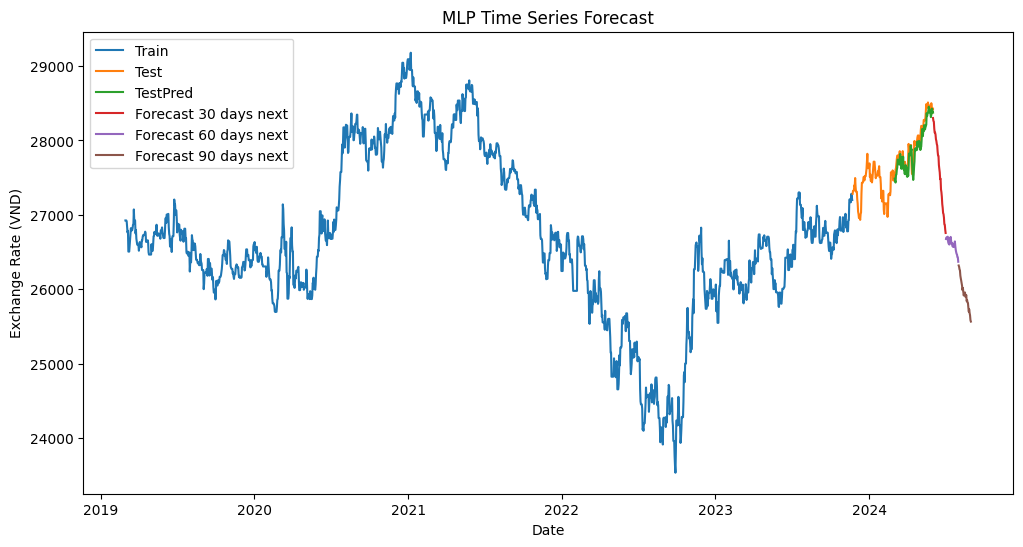

RMSE = 123.8040575366987
MAPE(%) = 0.3568746656119238
MAE = 99.8657651154891


In [13]:
implement_MLP(train_eur_3_sc, test_eur_3_sc)

# GBP - VND

In [14]:
# Scale data
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
 ## case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
 ## case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.96033293]
101
1 day input [0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.8030303  0.8030303  0.82391482 0.82760033 0.84657385
 0.84862135 0.86936937 0.86936937 0.86936937 0.87401037 0.85681136
 0.86527437 0.87278187 0.85544636 0.85544636 0.85544636 0.85517336
 0.84220584 0.85394485 0.87728638 0.81381381 0.81381381 0.81381381
 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783 0.83237783
 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887 0.86117936
 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94

8 day output [[0.8827181]]
9 day input [0.8030303  0.82391482 0.82760033 0.84657385 0.84862135 0.86936937
 0.86936937 0.86936937 0.87401037 0.85681136 0.86527437 0.87278187
 0.85544636 0.85544636 0.85544636 0.85517336 0.84220584 0.85394485
 0.87728638 0.81381381 0.81381381 0.81381381 0.81599782 0.83292383
 0.82814633 0.81872782 0.83237783 0.83237783 0.83237783 0.82855583
 0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0

18 day output [[0.7756694]]
19 day input [0.86527437 0.87278187 0.85544636 0.85544636 0.85544636 0.85517336
 0.84220584 0.85394485 0.87728638 0.81381381 0.81381381 0.81381381
 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783 0.83237783
 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887 0.86117936
 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.96033293 0.94572645 0.94785142
 0.94814461 0.9286427

28 day output [[0.6897601]]
29 day input [0.81381381 0.81381381 0.81599782 0.83292383 0.82814633 0.81872782
 0.83237783 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185
 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.96033293
 0.94572645 0.94785142 0.94814461 0.92864275 0.9118731  0.91358423
 0.89609194 0.88271809 0.8732993  0.86128587 0.85022962 0.84315896
 0.83175516 0.8122297

38 day output [[0.6295345]]
39 day input [0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.96033293 0.94572645 0.94785142 0.94814461 0.92864275
 0.9118731  0.91358423 0.89609194 0.88271809 0.8732993  0.86128587
 0.85022962 0.84315896 0.83175516 0.81222975 0.80018276 0.77817202
 0.78028333 0.7756694  0.76805741 0.75547773 0.74427623 0.72627246
 0.71943188 0.72022635

46 day output [[0.57855636]]
47 day input [0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.96033293
 0.94572645 0.94785142 0.94814461 0.92864275 0.9118731  0.91358423
 0.89609194 0.88271809 0.8732993  0.86128587 0.85022962 0.84315896
 0.83175516 0.81222975 0.80018276 0.77817202 0.78028333 0.7756694
 0.76805741 0.75547773 0.74427623 0.72627246 0.71943188 0.72022635
 0.71888089 0.72088313 0.70695871 0.68976009 0.68739182 0.69439071
 0.6835956  0.6841071

54 day output [[0.5155448]]
55 day input [0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.96033293 0.94572645 0.94785142
 0.94814461 0.92864275 0.9118731  0.91358423 0.89609194 0.88271809
 0.8732993  0.86128587 0.85022962 0.84315896 0.83175516 0.81222975
 0.80018276 0.77817202 0.78028333 0.7756694  0.76805741 0.75547773
 0.74427623 0.72627246 0.71943188 0.72022635 0.71888089 0.72088313
 0.70695871 0.68976009 0.68739182 0.69439071 0.6835956  0.68410712
 0.68512231 0.67228621 0.66688681 0.65722805 0.6469366  0.62953448
 0.62067837 0.6234630

62 day output [[0.48318768]]
63 day input [0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.96033293 0.94572645 0.94785142 0.94814461 0.92864275
 0.9118731  0.91358423 0.89609194 0.88271809 0.8732993  0.86128587
 0.85022962 0.84315896 0.83175516 0.81222975 0.80018276 0.77817202
 0.78028333 0.7756694  0.76805741 0.75547773 0.74427623 0.72627246
 0.71943188 0.72022635 0.71888089 0.72088313 0.70695871 0.68976009
 0.68739182 0.69439071 0.6835956  0.68410712 0.68512231 0.67228621
 0.66688681 0.65722805 0.6469366  0.62953448 0.62067837 0.62346303
 0.61912203 0.60436416 0.60394949 0.5994615  0.58543581 0.57855636
 0.57622731 0.5738858

70 day output [[0.46239942]]
71 day input [0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.96033293
 0.94572645 0.94785142 0.94814461 0.92864275 0.9118731  0.91358423
 0.89609194 0.88271809 0.8732993  0.86128587 0.85022962 0.84315896
 0.83175516 0.81222975 0.80018276 0.77817202 0.78028333 0.7756694
 0.76805741 0.75547773 0.74427623 0.72627246 0.71943188 0.72022635
 0.71888089 0.72088313 0.70695871 0.68976009 0.68739182 0.69439071
 0.6835956  0.68410712 0.68512231 0.67228621 0.66688681 0.65722805
 0.6469366  0.62953448 0.62067837 0.62346303 0.61912203 0.60436416
 0.60394949 0.5994615  0.58543581 0.57855636 0.57622731 0.5738858
 0.56549597 0.54647052 0.53579766 0.53179711 0.52367508 0.51554477
 0.52234262 0.52125484

79 day output [[0.49776083]]
80 day input [0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.96033293 0.94572645 0.94785142 0.94814461
 0.92864275 0.9118731  0.91358423 0.89609194 0.88271809 0.8732993
 0.86128587 0.85022962 0.84315896 0.83175516 0.81222975 0.80018276
 0.77817202 0.78028333 0.7756694  0.76805741 0.75547773 0.74427623
 0.72627246 0.71943188 0.72022635 0.71888089 0.72088313 0.70695871
 0.68976009 0.68739182 0.69439071 0.6835956  0.68410712 0.68512231
 0.67228621 0.66688681 0.65722805 0.6469366  0.62953448 0.62067837
 0.62346303 0.61912203 0.60436416 0.60394949 0.5994615  0.58543581
 0.57855636 0.57622731 0.5738858  0.56549597 0.54647052 0.53579766
 0.53179711 0.52367508 0.51554477 0.52234262 0.52125484 0.50302678
 0.49431828 0.49332029 0.49297211 0.48347706 0.48318768 0.48361889
 0.47655338 0.4691645

87 day output [[0.52865314]]
88 day input [0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.96033293 0.94572645 0.94785142 0.94814461 0.92864275 0.9118731
 0.91358423 0.89609194 0.88271809 0.8732993  0.86128587 0.85022962
 0.84315896 0.83175516 0.81222975 0.80018276 0.77817202 0.78028333
 0.7756694  0.76805741 0.75547773 0.74427623 0.72627246 0.71943188
 0.72022635 0.71888089 0.72088313 0.70695871 0.68976009 0.68739182
 0.69439071 0.6835956  0.68410712 0.68512231 0.67228621 0.66688681
 0.65722805 0.6469366  0.62953448 0.62067837 0.62346303 0.61912203
 0.60436416 0.60394949 0.5994615  0.58543581 0.57855636 0.57622731
 0.5738858  0.56549597 0.54647052 0.53579766 0.53179711 0.52367508
 0.51554477 0.52234262 0.52125484 0.50302678 0.49431828 0.49332029
 0.49297211 0.48347706 0.48318768 0.48361889 0.47655338 0.46916458
 0.46888289 0.46898544 0.46284318 0.46432495 0.46239942 0.47335312
 0.47107062 0.4695105

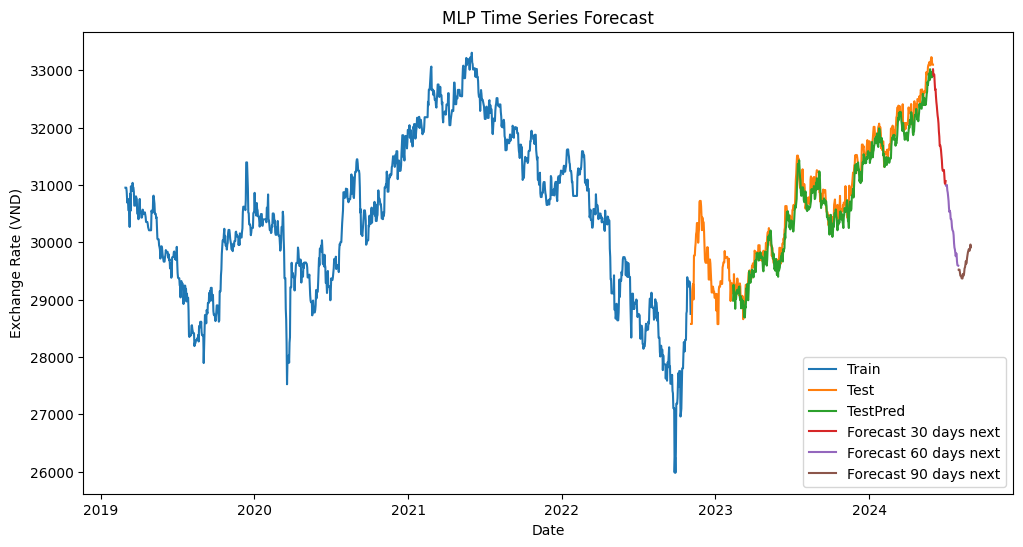

RMSE = 213.8377079677803
MAPE(%) = 0.5689749756343514
MAE = 176.7256228663341


In [15]:
implement_MLP(train_gbp_1_sc, test_gbp_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[0.9832709]
101
1 day input [0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.8030303  0.8030303  0.82391482 0.82760033 0.84657385
 0.84862135 0.86936937 0.86936937 0.86936937 0.87401037 0.85681136
 0.86527437 0.87278187 0.85544636 0.85544636 0.85544636 0.85517336
 0.84220584 0.85394485 0.87728638 0.81381381 0.81381381 0.81381381
 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783 0.83237783
 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887 0.86117936
 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840

9 day output [[1.0293736]]
10 day input [0.82391482 0.82760033 0.84657385 0.84862135 0.86936937 0.86936937
 0.86936937 0.87401037 0.85681136 0.86527437 0.87278187 0.85544636
 0.85544636 0.85544636 0.85517336 0.84220584 0.85394485 0.87728638
 0.81381381 0.81381381 0.81381381 0.81599782 0.83292383 0.82814633
 0.81872782 0.83237783 0.83237783 0.83237783 0.82855583 0.83060333
 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986
 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533
 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588
 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589
 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044
 0.91195741 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239
 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641
 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 

17 day output [[1.0657588]]
18 day input [0.85681136 0.86527437 0.87278187 0.85544636 0.85544636 0.85544636
 0.85517336 0.84220584 0.85394485 0.87728638 0.81381381 0.81381381
 0.81381381 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783
 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887
 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238
 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685
 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635
 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589
 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191
 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291
 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345
 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.98826099 0.97229047 0.97147147 0.97147147 0.98327088 0.99774414
 1.00230074 1.0029987

26 day output [[1.135306]]
27 day input [0.87728638 0.81381381 0.81381381 0.81381381 0.81599782 0.83292383
 0.82814633 0.81872782 0.83237783 0.83237783 0.83237783 0.82855583
 0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.98327088 0.99774414 1.00230074 1.00299871 1.02057076
 1.02761197 1.02252483 1.03317571 1.03394413 1.02937365 1.0457536
 1.05024028 1.05341589 1

34 day output [[1.1891359]]
35 day input [0.83237783 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185
 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.98327088
 0.99774414 1.00230074 1.00299871 1.02057076 1.02761197 1.02252483
 1.03317571 1.03394413 1.02937365 1.0457536  1.05024028 1.05341589
 1.05683351 1.06390452 1.06085098 1.04896045 1.06575882 1.07629585
 1.08035457 1.0969935

42 day output [[1.2363852]]
43 day input [0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.98327088 0.99774414 1.00230074
 1.00299871 1.02057076 1.02761197 1.02252483 1.03317571 1.03394413
 1.02937365 1.0457536  1.05024028 1.05341589 1.05683351 1.06390452
 1.06085098 1.04896045 1.06575882 1.07629585 1.08035457 1.09699357
 1.09837615 1.10305297 1.10427368 1.10866523 1.13128412 1.135306
 1.15040767 1.1578095  

51 day output [[1.2963064]]
52 day input [0.84930385 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588
 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589
 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044
 0.91195741 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239
 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641
 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.98327088 0.99774414 1.00230074 1.00299871 1.02057076 1.02761197
 1.02252483 1.03317571 1.03394413 1.02937365 1.0457536  1.05024028
 1.05341589 1.05683351 1.06390452 1.06085098 1.04896045 1.06575882
 1.07629585 1.08035457 1.09699357 1.09837615 1.10305297 1.10427368
 1.10866523 1.13128412 1.135306   1.15040767 1.1578095  1.16266847
 1.17139828 1.17306852 1.17130744 1.17740619 1.18913591 1.19805622
 1.19926786 1.20343232

63 day output [[1.3734945]]
64 day input [0.88861589 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044
 0.91195741 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239
 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641
 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.98327088 0.99774414 1.00230074 1.00299871 1.02057076 1.02761197
 1.02252483 1.03317571 1.03394413 1.02937365 1.0457536  1.05024028
 1.05341589 1.05683351 1.06390452 1.06085098 1.04896045 1.06575882
 1.07629585 1.08035457 1.09699357 1.09837615 1.10305297 1.10427368
 1.10866523 1.13128412 1.135306   1.15040767 1.1578095  1.16266847
 1.17139828 1.17306852 1.17130744 1.17740619 1.18913591 1.19805622
 1.19926786 1.20343232 1.20666754 1.20758402 1.21581244 1.22005808
 1.23638523 1.23765898 1.24024594 1.2584492  1.2587831  1.26606476
 1.2754159  1.27986157

73 day output [[1.4591769]]
74 day input [0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.98327088 0.99774414 1.00230074 1.00299871
 1.02057076 1.02761197 1.02252483 1.03317571 1.03394413 1.02937365
 1.0457536  1.05024028 1.05341589 1.05683351 1.06390452 1.06085098
 1.04896045 1.06575882 1.07629585 1.08035457 1.09699357 1.09837615
 1.10305297 1.10427368 1.10866523 1.13128412 1.135306   1.15040767
 1.1578095  1.16266847 1.17139828 1.17306852 1.17130744 1.17740619
 1.18913591 1.19805622 1.19926786 1.20343232 1.20666754 1.20758402
 1.21581244 1.22005808 1.23638523 1.23765898 1.24024594 1.2584492
 1.2587831  1.26606476 1.2754159  1.27986157 1.29054725 1.29630637
 1.30230308 1.3088305  1.32106519 1.32867587 1.33100915 1.34365046
 1.35397363 1.34747076

82 day output [[1.5203035]]
83 day input [0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.98327088
 0.99774414 1.00230074 1.00299871 1.02057076 1.02761197 1.02252483
 1.03317571 1.03394413 1.02937365 1.0457536  1.05024028 1.05341589
 1.05683351 1.06390452 1.06085098 1.04896045 1.06575882 1.07629585
 1.08035457 1.09699357 1.09837615 1.10305297 1.10427368 1.10866523
 1.13128412 1.135306   1.15040767 1.1578095  1.16266847 1.17139828
 1.17306852 1.17130744 1.17740619 1.18913591 1.19805622 1.19926786
 1.20343232 1.20666754 1.20758402 1.21581244 1.22005808 1.23638523
 1.23765898 1.24024594 1.2584492  1.2587831  1.26606476 1.2754159
 1.27986157 1.29054725 1.29630637 1.30230308 1.3088305  1.32106519
 1.32867587 1.33100915 1.34365046 1.35397363 1.34747076 1.35564029
 1.36564159 1.37119758 1.37349451 1.37909448 1.3884629  1.39025879
 1.40516424 1.4159435 

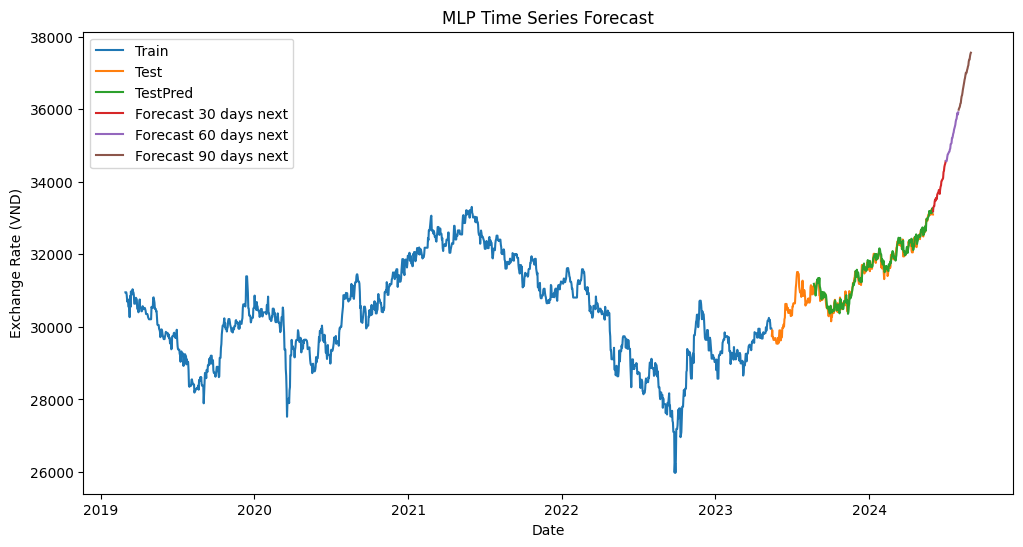

RMSE = 133.42036950817356
MAPE(%) = 0.32594782829186797
MAE = 102.63358962367978


In [16]:
implement_MLP(train_gbp_2_sc, test_gbp_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[0.9955837]
101
1 day input [0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.8030303  0.8030303  0.82391482 0.82760033 0.84657385
 0.84862135 0.86936937 0.86936937 0.86936937 0.87401037 0.85681136
 0.86527437 0.87278187 0.85544636 0.85544636 0.85544636 0.85517336
 0.84220584 0.85394485 0.87728638 0.81381381 0.81381381 0.81381381
 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783 0.83237783
 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887 0.86117936
 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840

8 day output [[1.0651767]]
9 day input [0.8030303  0.82391482 0.82760033 0.84657385 0.84862135 0.86936937
 0.86936937 0.86936937 0.87401037 0.85681136 0.86527437 0.87278187
 0.85544636 0.85544636 0.85544636 0.85517336 0.84220584 0.85394485
 0.87728638 0.81381381 0.81381381 0.81381381 0.81599782 0.83292383
 0.82814633 0.81872782 0.83237783 0.83237783 0.83237783 0.82855583
 0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0

18 day output [[1.1535009]]
19 day input [0.86527437 0.87278187 0.85544636 0.85544636 0.85544636 0.85517336
 0.84220584 0.85394485 0.87728638 0.81381381 0.81381381 0.81381381
 0.81599782 0.83292383 0.82814633 0.81872782 0.83237783 0.83237783
 0.83237783 0.82855583 0.83060333 0.84548185 0.86977887 0.86117936
 0.86117936 0.86117936 0.85530986 0.86759487 0.87783238 0.83606334
 0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.99558371 0.98530179 1.00991213
 1.02741468 1.0230168

28 day output [[1.256482]]
29 day input [0.81381381 0.81381381 0.81599782 0.83292383 0.82814633 0.81872782
 0.83237783 0.83237783 0.83237783 0.82855583 0.83060333 0.84548185
 0.86977887 0.86117936 0.86117936 0.86117936 0.85530986 0.86759487
 0.87783238 0.83606334 0.82896533 0.82896533 0.82896533 0.84930385
 0.85230685 0.88329238 0.88452088 0.87769588 0.87769588 0.87769588
 0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.99558371
 0.98530179 1.00991213 1.02741468 1.02301681 1.03846252 1.06186664
 1.05872619 1.06517673 1.07022274 1.08759332 1.09514487 1.09026778
 1.11324477 1.1209923 

38 day output [[1.339429]]
39 day input [0.83060333 0.84548185 0.86977887 0.86117936 0.86117936 0.86117936
 0.85530986 0.86759487 0.87783238 0.83606334 0.82896533 0.82896533
 0.82896533 0.84930385 0.85230685 0.88329238 0.88452088 0.87769588
 0.87769588 0.87769588 0.84998635 0.84875785 0.86636637 0.88970789
 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424  0.87878788
 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.99558371 0.98530179 1.00991213 1.02741468 1.02301681
 1.03846252 1.06186664 1.05872619 1.06517673 1.07022274 1.08759332
 1.09514487 1.09026778 1.11324477 1.1209923  1.11279428 1.12907732
 1.13873696 1.15350091 1.15266955 1.18083823 1.17521024 1.18868196
 1.19909751 1.20651913 

48 day output [[1.4331385]]
49 day input [0.82896533 0.82896533 0.82896533 0.84930385 0.85230685 0.88329238
 0.88452088 0.87769588 0.87769588 0.87769588 0.84998635 0.84875785
 0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.99558371 0.98530179 1.00991213
 1.02741468 1.02301681 1.03846252 1.06186664 1.05872619 1.06517673
 1.07022274 1.08759332 1.09514487 1.09026778 1.11324477 1.1209923
 1.11279428 1.12907732 1.13873696 1.15350091 1.15266955 1.18083823
 1.17521024 1.18868196 1.19909751 1.20651913 1.22827744 1.23985052
 1.24662352 1.25648201 1.26466286 1.27615213 1.28690517 1.27826726
 1.30210149 1.31148291

58 day output [[1.5254449]]
59 day input [0.84998635 0.84875785 0.86636637 0.88970789 0.88861589 0.88861589
 0.88861589 0.88520339 0.8969424  0.87878788 0.8953044  0.91195741
 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.99558371
 0.98530179 1.00991213 1.02741468 1.02301681 1.03846252 1.06186664
 1.05872619 1.06517673 1.07022274 1.08759332 1.09514487 1.09026778
 1.11324477 1.1209923  1.11279428 1.12907732 1.13873696 1.15350091
 1.15266955 1.18083823 1.17521024 1.18868196 1.19909751 1.20651913
 1.22827744 1.23985052 1.24662352 1.25648201 1.26466286 1.27615213
 1.28690517 1.27826726 1.30210149 1.31148291 1.31235027 1.32186031
 1.3331238  1.33942902 1.34137011 1.36086893 1.3681674  1.37711143
 1.38550019 1.3968460

68 day output [[1.6158446]]
69 day input [0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.99558371 0.98530179 1.00991213 1.02741468 1.02301681
 1.03846252 1.06186664 1.05872619 1.06517673 1.07022274 1.08759332
 1.09514487 1.09026778 1.11324477 1.1209923  1.11279428 1.12907732
 1.13873696 1.15350091 1.15266955 1.18083823 1.17521024 1.18868196
 1.19909751 1.20651913 1.22827744 1.23985052 1.24662352 1.25648201
 1.26466286 1.27615213 1.28690517 1.27826726 1.30210149 1.31148291
 1.31235027 1.32186031 1.3331238  1.33942902 1.34137011 1.36086893
 1.3681674  1.37711143 1.38550019 1.39684606 1.40793204 1.42286217
 1.42863524 1.43313849 1.43862021 1.44658184 1.45146906 1.45991659
 1.48201525 1.49059474

78 day output [[1.738255]]
79 day input [0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.99558371 0.98530179 1.00991213
 1.02741468 1.02301681 1.03846252 1.06186664 1.05872619 1.06517673
 1.07022274 1.08759332 1.09514487 1.09026778 1.11324477 1.1209923
 1.11279428 1.12907732 1.13873696 1.15350091 1.15266955 1.18083823
 1.17521024 1.18868196 1.19909751 1.20651913 1.22827744 1.23985052
 1.24662352 1.25648201 1.26466286 1.27615213 1.28690517 1.27826726
 1.30210149 1.31148291 1.31235027 1.32186031 1.3331238  1.33942902
 1.34137011 1.36086893 1.3681674  1.37711143 1.38550019 1.39684606
 1.40793204 1.42286217 1.42863524 1.43313849 1.43862021 1.44658184
 1.45146906 1.45991659 1.48201525 1.49059474 1.49273169 1.51414931
 1.51213396 1.52544487 1.5276407  1.54622388 1.55256701 1.5639298
 1.56632888 1.5816977  1

88 day output [[1.8422837]]
89 day input [0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.99558371
 0.98530179 1.00991213 1.02741468 1.02301681 1.03846252 1.06186664
 1.05872619 1.06517673 1.07022274 1.08759332 1.09514487 1.09026778
 1.11324477 1.1209923  1.11279428 1.12907732 1.13873696 1.15350091
 1.15266955 1.18083823 1.17521024 1.18868196 1.19909751 1.20651913
 1.22827744 1.23985052 1.24662352 1.25648201 1.26466286 1.27615213
 1.28690517 1.27826726 1.30210149 1.31148291 1.31235027 1.32186031
 1.3331238  1.33942902 1.34137011 1.36086893 1.3681674  1.37711143
 1.38550019 1.39684606 1.40793204 1.42286217 1.42863524 1.43313849
 1.43862021 1.44658184 1.45146906 1.45991659 1.48201525 1.49059474
 1.49273169 1.51414931 1.51213396 1.52544487 1.5276407  1.54622388
 1.55256701 1.5639298  1.56632888 1.5816977  1.58173525 1.6040138
 1.60878932 1.61584461 1.63321376 1.6458807  1.65586901 1.66369808
 1.68490648 1.68833208

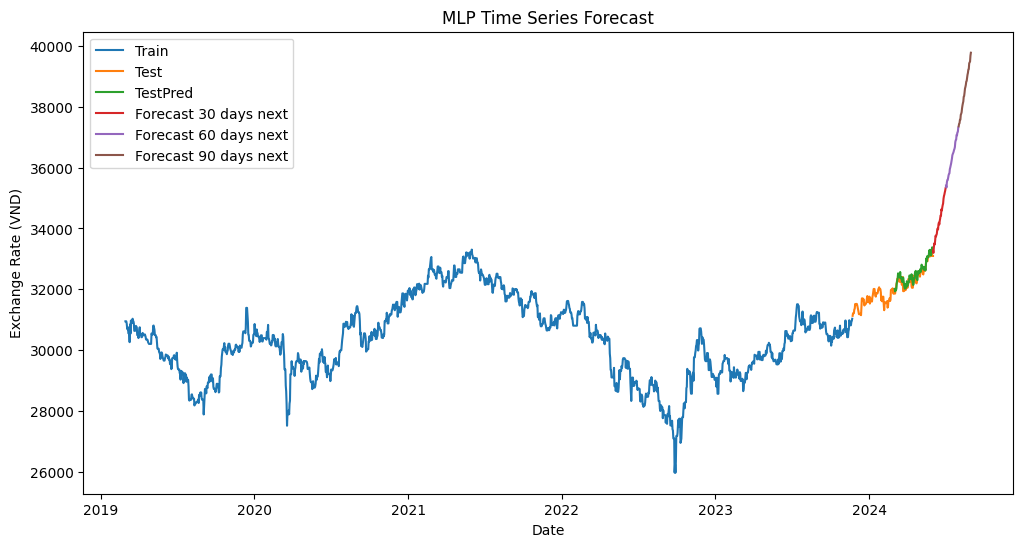

RMSE = 153.6716650896998
MAPE(%) = 0.37756107104165726
MAE = 122.26044497282605


In [17]:
implement_MLP(train_gbp_3_sc, test_gbp_3_sc)

# JPY - VND


In [18]:
# Scale data
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
 ## case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
 ## case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.0248295]
101
1 day input [0.05156951 0.05156951 0.05685458 0.05477258 0.04580397 0.06534273
 0.04868674 0.04868674 0.04868674 0.05893658 0.05893658 0.07110826
 0.10313901 0.10185778 0.10185778 0.10185778 0.12139654 0.10938501
 0.10345932 0.10474055 0.0941704  0.0941704  0.0941704  0.08392056
 0.06646381 0.05188981 0.05813581 0.05028828 0.05028828 0.05028828
 0.04996797 0.05285074 0.05076874 0.05092889 0.05621397 0.05621397
 0.05621397 0.05445227 0.06262012 0.06726457 0.06566304 0.07110826
 0.07110826 0.07110826 0.06165919 0.06165919 0.06149904 0.04115951
 0.04452274 0.04452274 0.04452274 0.05301089 0.05172966 0.06518258
 0.06806534 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935
 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.047

8 day output [[0.01725363]]
9 day input [0.04868674 0.05893658 0.05893658 0.07110826 0.10313901 0.10185778
 0.10185778 0.10185778 0.12139654 0.10938501 0.10345932 0.10474055
 0.0941704  0.0941704  0.0941704  0.08392056 0.06646381 0.05188981
 0.05813581 0.05028828 0.05028828 0.05028828 0.04996797 0.05285074
 0.05076874 0.05092889 0.05621397 0.05621397 0.05621397 0.05445227
 0.06262012 0.06726457 0.06566304 0.07110826 0.07110826 0.07110826
 0.06165919 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274
 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519
 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813
 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645 0.
 0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.026105

18 day output [[-0.00619209]]
19 day input [ 0.10345932  0.10474055  0.0941704   0.0941704   0.0941704   0.08392056
  0.06646381  0.05188981  0.05813581  0.05028828  0.05028828  0.05028828
  0.04996797  0.05285074  0.05076874  0.05092889  0.05621397  0.05621397
  0.05621397  0.05445227  0.06262012  0.06726457  0.06566304  0.07110826
  0.07110826  0.07110826  0.06165919  0.06165919  0.06149904  0.04115951
  0.04452274  0.04452274  0.04452274  0.05301089  0.05172966  0.06518258
  0.06806534  0.06790519  0.06790519  0.06790519  0.06454196  0.06181935
  0.0578155   0.03971813  0.02370275  0.02370275  0.02370275  0.03539398
  0.01713645  0.          0.05188981  0.08728379  0.09096733  0.09096733
  0.07399103  0.06278027  0.05076874  0.04324151  0.04596413  0.04596413
  0.04596413  0.04436259  0.03587444  0.04228059  0.06374119  0.0470852
  0.0470852   0.0470852   0.04788597  0.04003844  0.03619475  0.0318706
  0.02674568  0.02674568  0.02674568  0.02834721  0.02610506  0.02466368
  0.027226

25 day output [[0.00171867]]
26 day input [ 0.05188981  0.05813581  0.05028828  0.05028828  0.05028828  0.04996797
  0.05285074  0.05076874  0.05092889  0.05621397  0.05621397  0.05621397
  0.05445227  0.06262012  0.06726457  0.06566304  0.07110826  0.07110826
  0.07110826  0.06165919  0.06165919  0.06149904  0.04115951  0.04452274
  0.04452274  0.04452274  0.05301089  0.05172966  0.06518258  0.06806534
  0.06790519  0.06790519  0.06790519  0.06454196  0.06181935  0.0578155
  0.03971813  0.02370275  0.02370275  0.02370275  0.03539398  0.01713645
  0.          0.05188981  0.08728379  0.09096733  0.09096733  0.07399103
  0.06278027  0.05076874  0.04324151  0.04596413  0.04596413  0.04596413
  0.04436259  0.03587444  0.04228059  0.06374119  0.0470852   0.0470852
  0.0470852   0.04788597  0.04003844  0.03619475  0.0318706   0.02674568
  0.02674568  0.02674568  0.02834721  0.02610506  0.02466368  0.02722614
  0.02017937  0.02017937  0.0248295   0.02969239  0.02590872  0.02077909
  0.0225472

33 day output [[0.00388152]]
34 day input [ 0.05092889  0.05621397  0.05621397  0.05621397  0.05445227  0.06262012
  0.06726457  0.06566304  0.07110826  0.07110826  0.07110826  0.06165919
  0.06165919  0.06149904  0.04115951  0.04452274  0.04452274  0.04452274
  0.05301089  0.05172966  0.06518258  0.06806534  0.06790519  0.06790519
  0.06790519  0.06454196  0.06181935  0.0578155   0.03971813  0.02370275
  0.02370275  0.02370275  0.03539398  0.01713645  0.          0.05188981
  0.08728379  0.09096733  0.09096733  0.07399103  0.06278027  0.05076874
  0.04324151  0.04596413  0.04596413  0.04596413  0.04436259  0.03587444
  0.04228059  0.06374119  0.0470852   0.0470852   0.0470852   0.04788597
  0.04003844  0.03619475  0.0318706   0.02674568  0.02674568  0.02674568
  0.02834721  0.02610506  0.02466368  0.02722614  0.02017937  0.02017937
  0.0248295   0.02969239  0.02590872  0.02077909  0.02254722  0.03357617
  0.02250608  0.0257784   0.01725363  0.01615676  0.02403498  0.01746385
  0.01465

40 day output [[0.0092632]]
41 day input [ 0.06566304  0.07110826  0.07110826  0.07110826  0.06165919  0.06165919
  0.06149904  0.04115951  0.04452274  0.04452274  0.04452274  0.05301089
  0.05172966  0.06518258  0.06806534  0.06790519  0.06790519  0.06790519
  0.06454196  0.06181935  0.0578155   0.03971813  0.02370275  0.02370275
  0.02370275  0.03539398  0.01713645  0.          0.05188981  0.08728379
  0.09096733  0.09096733  0.07399103  0.06278027  0.05076874  0.04324151
  0.04596413  0.04596413  0.04596413  0.04436259  0.03587444  0.04228059
  0.06374119  0.0470852   0.0470852   0.0470852   0.04788597  0.04003844
  0.03619475  0.0318706   0.02674568  0.02674568  0.02674568  0.02834721
  0.02610506  0.02466368  0.02722614  0.02017937  0.02017937  0.0248295
  0.02969239  0.02590872  0.02077909  0.02254722  0.03357617  0.02250608
  0.0257784   0.01725363  0.01615676  0.02403498  0.01746385  0.01465571
  0.01332132  0.00621469  0.01088892  0.01817854  0.01104743 -0.00619209
 -0.0101398

48 day output [[0.00725989]]
49 day input [ 0.04452274  0.04452274  0.04452274  0.05301089  0.05172966  0.06518258
  0.06806534  0.06790519  0.06790519  0.06790519  0.06454196  0.06181935
  0.0578155   0.03971813  0.02370275  0.02370275  0.02370275  0.03539398
  0.01713645  0.          0.05188981  0.08728379  0.09096733  0.09096733
  0.07399103  0.06278027  0.05076874  0.04324151  0.04596413  0.04596413
  0.04596413  0.04436259  0.03587444  0.04228059  0.06374119  0.0470852
  0.0470852   0.0470852   0.04788597  0.04003844  0.03619475  0.0318706
  0.02674568  0.02674568  0.02674568  0.02834721  0.02610506  0.02466368
  0.02722614  0.02017937  0.02017937  0.0248295   0.02969239  0.02590872
  0.02077909  0.02254722  0.03357617  0.02250608  0.0257784   0.01725363
  0.01615676  0.02403498  0.01746385  0.01465571  0.01332132  0.00621469
  0.01088892  0.01817854  0.01104743 -0.00619209 -0.01013986 -0.00381937
 -0.00298249 -0.00722662 -0.0123264   0.00314063  0.00171867 -0.00669031
 -0.0091114

55 day output [[0.00113289]]
56 day input [ 0.06790519  0.06790519  0.06790519  0.06454196  0.06181935  0.0578155
  0.03971813  0.02370275  0.02370275  0.02370275  0.03539398  0.01713645
  0.          0.05188981  0.08728379  0.09096733  0.09096733  0.07399103
  0.06278027  0.05076874  0.04324151  0.04596413  0.04596413  0.04596413
  0.04436259  0.03587444  0.04228059  0.06374119  0.0470852   0.0470852
  0.0470852   0.04788597  0.04003844  0.03619475  0.0318706   0.02674568
  0.02674568  0.02674568  0.02834721  0.02610506  0.02466368  0.02722614
  0.02017937  0.02017937  0.0248295   0.02969239  0.02590872  0.02077909
  0.02254722  0.03357617  0.02250608  0.0257784   0.01725363  0.01615676
  0.02403498  0.01746385  0.01465571  0.01332132  0.00621469  0.01088892
  0.01817854  0.01104743 -0.00619209 -0.01013986 -0.00381937 -0.00298249
 -0.00722662 -0.0123264   0.00314063  0.00171867 -0.00669031 -0.00911145
  0.00081848  0.01459394  0.00549791 -0.00492804  0.00579498  0.00388152
  0.0063064

63 day output [[-0.01462629]]
64 day input [ 2.37027546e-02  2.37027546e-02  3.53939782e-02  1.71364510e-02
  0.00000000e+00  5.18898142e-02  8.72837924e-02  9.09673286e-02
  9.09673286e-02  7.39910314e-02  6.27802691e-02  5.07687380e-02
  4.32415119e-02  4.59641256e-02  4.59641256e-02  4.59641256e-02
  4.43625881e-02  3.58744395e-02  4.22805894e-02  6.37411915e-02
  4.70852018e-02  4.70852018e-02  4.70852018e-02  4.78859705e-02
  4.00384369e-02  3.61947470e-02  3.18705958e-02  2.67456758e-02
  2.67456758e-02  2.67456758e-02  2.83472133e-02  2.61050609e-02
  2.46636771e-02  2.72261371e-02  2.01793722e-02  2.01793722e-02
  2.48295013e-02  2.96923872e-02  2.59087197e-02  2.07790900e-02
  2.25472208e-02  3.35761681e-02  2.25060806e-02  2.57784016e-02
  1.72536317e-02  1.61567591e-02  2.40349770e-02  1.74638499e-02
  1.46557055e-02  1.33213205e-02  6.21469319e-03  1.08889248e-02
  1.81785375e-02  1.10474303e-02 -6.19209092e-03 -1.01398593e-02
 -3.81936925e-03 -2.98249046e-03 -7.22661521e-0

68 day output [[-0.00359851]]
69 day input [ 5.18898142e-02  8.72837924e-02  9.09673286e-02  9.09673286e-02
  7.39910314e-02  6.27802691e-02  5.07687380e-02  4.32415119e-02
  4.59641256e-02  4.59641256e-02  4.59641256e-02  4.43625881e-02
  3.58744395e-02  4.22805894e-02  6.37411915e-02  4.70852018e-02
  4.70852018e-02  4.70852018e-02  4.78859705e-02  4.00384369e-02
  3.61947470e-02  3.18705958e-02  2.67456758e-02  2.67456758e-02
  2.67456758e-02  2.83472133e-02  2.61050609e-02  2.46636771e-02
  2.72261371e-02  2.01793722e-02  2.01793722e-02  2.48295013e-02
  2.96923872e-02  2.59087197e-02  2.07790900e-02  2.25472208e-02
  3.35761681e-02  2.25060806e-02  2.57784016e-02  1.72536317e-02
  1.61567591e-02  2.40349770e-02  1.74638499e-02  1.46557055e-02
  1.33213205e-02  6.21469319e-03  1.08889248e-02  1.81785375e-02
  1.10474303e-02 -6.19209092e-03 -1.01398593e-02 -3.81936925e-03
 -2.98249046e-03 -7.22661521e-03 -1.23264035e-02  3.14063323e-03
  1.71866710e-03 -6.69031357e-03 -9.11145099e-0

73 day output [[-0.01535669]]
74 day input [ 6.27802691e-02  5.07687380e-02  4.32415119e-02  4.59641256e-02
  4.59641256e-02  4.59641256e-02  4.43625881e-02  3.58744395e-02
  4.22805894e-02  6.37411915e-02  4.70852018e-02  4.70852018e-02
  4.70852018e-02  4.78859705e-02  4.00384369e-02  3.61947470e-02
  3.18705958e-02  2.67456758e-02  2.67456758e-02  2.67456758e-02
  2.83472133e-02  2.61050609e-02  2.46636771e-02  2.72261371e-02
  2.01793722e-02  2.01793722e-02  2.48295013e-02  2.96923872e-02
  2.59087197e-02  2.07790900e-02  2.25472208e-02  3.35761681e-02
  2.25060806e-02  2.57784016e-02  1.72536317e-02  1.61567591e-02
  2.40349770e-02  1.74638499e-02  1.46557055e-02  1.33213205e-02
  6.21469319e-03  1.08889248e-02  1.81785375e-02  1.10474303e-02
 -6.19209092e-03 -1.01398593e-02 -3.81936925e-03 -2.98249046e-03
 -7.22661521e-03 -1.23264035e-02  3.14063323e-03  1.71866710e-03
 -6.69031357e-03 -9.11145099e-03  8.18475790e-04  1.45939365e-02
  5.49790962e-03 -4.92803566e-03  5.79497777e-0

78 day output [[-0.01817547]]
79 day input [ 4.59641256e-02  4.43625881e-02  3.58744395e-02  4.22805894e-02
  6.37411915e-02  4.70852018e-02  4.70852018e-02  4.70852018e-02
  4.78859705e-02  4.00384369e-02  3.61947470e-02  3.18705958e-02
  2.67456758e-02  2.67456758e-02  2.67456758e-02  2.83472133e-02
  2.61050609e-02  2.46636771e-02  2.72261371e-02  2.01793722e-02
  2.01793722e-02  2.48295013e-02  2.96923872e-02  2.59087197e-02
  2.07790900e-02  2.25472208e-02  3.35761681e-02  2.25060806e-02
  2.57784016e-02  1.72536317e-02  1.61567591e-02  2.40349770e-02
  1.74638499e-02  1.46557055e-02  1.33213205e-02  6.21469319e-03
  1.08889248e-02  1.81785375e-02  1.10474303e-02 -6.19209092e-03
 -1.01398593e-02 -3.81936925e-03 -2.98249046e-03 -7.22661521e-03
 -1.23264035e-02  3.14063323e-03  1.71866710e-03 -6.69031357e-03
 -9.11145099e-03  8.18475790e-04  1.45939365e-02  5.49790962e-03
 -4.92803566e-03  5.79497777e-03  3.88152036e-03  6.30646106e-03
  2.93826940e-03 -5.90092503e-03  1.39216776e-0

83 day output [[-0.00063934]]
84 day input [ 4.70852018e-02  4.70852018e-02  4.70852018e-02  4.78859705e-02
  4.00384369e-02  3.61947470e-02  3.18705958e-02  2.67456758e-02
  2.67456758e-02  2.67456758e-02  2.83472133e-02  2.61050609e-02
  2.46636771e-02  2.72261371e-02  2.01793722e-02  2.01793722e-02
  2.48295013e-02  2.96923872e-02  2.59087197e-02  2.07790900e-02
  2.25472208e-02  3.35761681e-02  2.25060806e-02  2.57784016e-02
  1.72536317e-02  1.61567591e-02  2.40349770e-02  1.74638499e-02
  1.46557055e-02  1.33213205e-02  6.21469319e-03  1.08889248e-02
  1.81785375e-02  1.10474303e-02 -6.19209092e-03 -1.01398593e-02
 -3.81936925e-03 -2.98249046e-03 -7.22661521e-03 -1.23264035e-02
  3.14063323e-03  1.71866710e-03 -6.69031357e-03 -9.11145099e-03
  8.18475790e-04  1.45939365e-02  5.49790962e-03 -4.92803566e-03
  5.79497777e-03  3.88152036e-03  6.30646106e-03  2.93826940e-03
 -5.90092503e-03  1.39216776e-03  2.50651012e-03  4.99956729e-03
  9.26320069e-03  1.30815636e-02  1.47366151e-0

88 day output [[-0.01740807]]
89 day input [ 3.61947470e-02  3.18705958e-02  2.67456758e-02  2.67456758e-02
  2.67456758e-02  2.83472133e-02  2.61050609e-02  2.46636771e-02
  2.72261371e-02  2.01793722e-02  2.01793722e-02  2.48295013e-02
  2.96923872e-02  2.59087197e-02  2.07790900e-02  2.25472208e-02
  3.35761681e-02  2.25060806e-02  2.57784016e-02  1.72536317e-02
  1.61567591e-02  2.40349770e-02  1.74638499e-02  1.46557055e-02
  1.33213205e-02  6.21469319e-03  1.08889248e-02  1.81785375e-02
  1.10474303e-02 -6.19209092e-03 -1.01398593e-02 -3.81936925e-03
 -2.98249046e-03 -7.22661521e-03 -1.23264035e-02  3.14063323e-03
  1.71866710e-03 -6.69031357e-03 -9.11145099e-03  8.18475790e-04
  1.45939365e-02  5.49790962e-03 -4.92803566e-03  5.79497777e-03
  3.88152036e-03  6.30646106e-03  2.93826940e-03 -5.90092503e-03
  1.39216776e-03  2.50651012e-03  4.99956729e-03  9.26320069e-03
  1.30815636e-02  1.47366151e-02  1.61982495e-02  2.28733812e-02
  1.52127761e-02  7.84829259e-03  1.05341403e-0

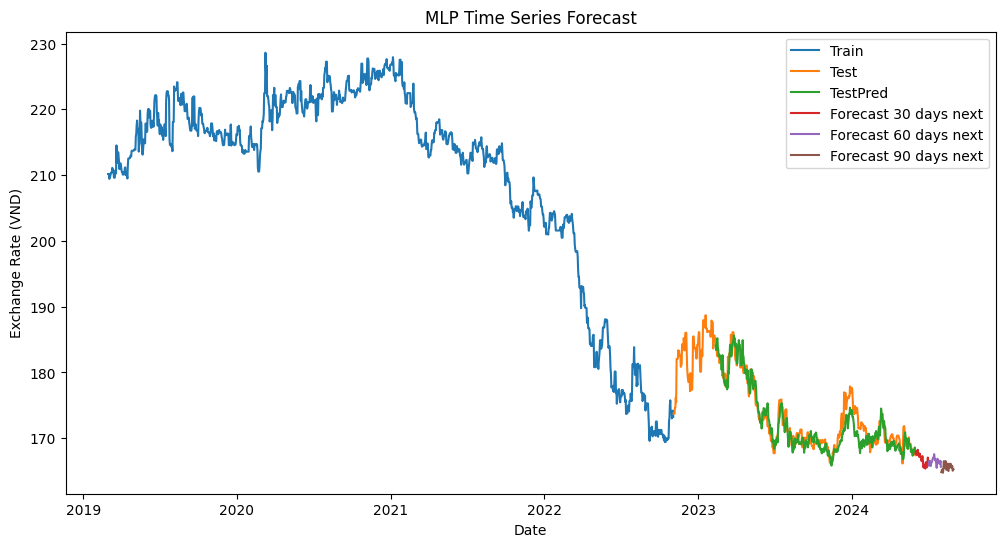

RMSE = 1.6694669410618141
MAPE(%) = 0.7510441201910089
MAE = 1.3047923573726363


In [19]:
implement_MLP(train_jpy_1_sc, test_jpy_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.01720383]
101
1 day input [0.05156951 0.05156951 0.05685458 0.05477258 0.04580397 0.06534273
 0.04868674 0.04868674 0.04868674 0.05893658 0.05893658 0.07110826
 0.10313901 0.10185778 0.10185778 0.10185778 0.12139654 0.10938501
 0.10345932 0.10474055 0.0941704  0.0941704  0.0941704  0.08392056
 0.06646381 0.05188981 0.05813581 0.05028828 0.05028828 0.05028828
 0.04996797 0.05285074 0.05076874 0.05092889 0.05621397 0.05621397
 0.05621397 0.05445227 0.06262012 0.06726457 0.06566304 0.07110826
 0.07110826 0.07110826 0.06165919 0.06165919 0.06149904 0.04115951
 0.04452274 0.04452274 0.04452274 0.05301089 0.05172966 0.06518258
 0.06806534 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935
 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470

8 day output [[0.03633798]]
9 day input [0.04868674 0.05893658 0.05893658 0.07110826 0.10313901 0.10185778
 0.10185778 0.10185778 0.12139654 0.10938501 0.10345932 0.10474055
 0.0941704  0.0941704  0.0941704  0.08392056 0.06646381 0.05188981
 0.05813581 0.05028828 0.05028828 0.05028828 0.04996797 0.05285074
 0.05076874 0.05092889 0.05621397 0.05621397 0.05621397 0.05445227
 0.06262012 0.06726457 0.06566304 0.07110826 0.07110826 0.07110826
 0.06165919 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274
 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519
 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813
 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645 0.
 0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.026105

18 day output [[0.12954739]]
19 day input [0.10345932 0.10474055 0.0941704  0.0941704  0.0941704  0.08392056
 0.06646381 0.05188981 0.05813581 0.05028828 0.05028828 0.05028828
 0.04996797 0.05285074 0.05076874 0.05092889 0.05621397 0.05621397
 0.05621397 0.05445227 0.06262012 0.06726457 0.06566304 0.07110826
 0.07110826 0.07110826 0.06165919 0.06165919 0.06149904 0.04115951
 0.04452274 0.04452274 0.04452274 0.05301089 0.05172966 0.06518258
 0.06806534 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935
 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01720383 0.01381245 0.01814165
 0.01328516 0.01912431

28 day output [[0.20452942]]
29 day input [0.05028828 0.05028828 0.04996797 0.05285074 0.05076874 0.05092889
 0.05621397 0.05621397 0.05621397 0.05445227 0.06262012 0.06726457
 0.06566304 0.07110826 0.07110826 0.07110826 0.06165919 0.06165919
 0.06149904 0.04115951 0.04452274 0.04452274 0.04452274 0.05301089
 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519 0.06790519
 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275
 0.02370275 0.03539398 0.01713645 0.         0.05188981 0.08728379
 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151
 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059
 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721
 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937 0.01720383
 0.01381245 0.01814165 0.01328516 0.01912431 0.02028523 0.02100422
 0.02653788 0.03633798 0.04450005 0.04994841 0.06455261 0.08429532
 0.09203723 0.108244

38 day output [[0.19622993]]
39 day input [0.06262012 0.06726457 0.06566304 0.07110826 0.07110826 0.07110826
 0.06165919 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274
 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519
 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813
 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645 0.
 0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.01720383 0.01381245 0.01814165 0.01328516 0.01912431
 0.02028523 0.02100422 0.02653788 0.03633798 0.04450005 0.04994841
 0.06455261 0.08429532 0.09203723 0.10824464 0.11164173 0.11626598
 0.12836039 0.12954739 0.14950481 0.16170731 0.16884542 0.17612489
 0.17012186 0.18166666 0.1884

46 day output [[0.14619404]]
47 day input [0.06149904 0.04115951 0.04452274 0.04452274 0.04452274 0.05301089
 0.05172966 0.06518258 0.06806534 0.06790519 0.06790519 0.06790519
 0.06454196 0.06181935 0.0578155  0.03971813 0.02370275 0.02370275
 0.02370275 0.03539398 0.01713645 0.         0.05188981 0.08728379
 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874 0.04324151
 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444 0.04228059
 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844
 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721
 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937 0.01720383
 0.01381245 0.01814165 0.01328516 0.01912431 0.02028523 0.02100422
 0.02653788 0.03633798 0.04450005 0.04994841 0.06455261 0.08429532
 0.09203723 0.10824464 0.11164173 0.11626598 0.12836039 0.12954739
 0.14950481 0.16170731 0.16884542 0.17612489 0.17012186 0.18166666
 0.18847398 0.18722683 0.19864996 0.20452942 0.20993045 0.2088192
 0.20059727 0.2037668

54 day output [[0.10644817]]
55 day input [0.06806534 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935
 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01720383 0.01381245 0.01814165
 0.01328516 0.01912431 0.02028523 0.02100422 0.02653788 0.03633798
 0.04450005 0.04994841 0.06455261 0.08429532 0.09203723 0.10824464
 0.11164173 0.11626598 0.12836039 0.12954739 0.14950481 0.16170731
 0.16884542 0.17612489 0.17012186 0.18166666 0.18847398 0.18722683
 0.19864996 0.20452942 0.20993045 0.2088192  0.20059727 0.20376687
 0.21551782 0.22118007 0.21422476 0.22201031 0.21673168 0.19622993
 0.19629189 0.19140854

62 day output [[0.1532837]]
63 day input [0.02370275 0.02370275 0.02370275 0.03539398 0.01713645 0.
 0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.01720383 0.01381245 0.01814165 0.01328516 0.01912431
 0.02028523 0.02100422 0.02653788 0.03633798 0.04450005 0.04994841
 0.06455261 0.08429532 0.09203723 0.10824464 0.11164173 0.11626598
 0.12836039 0.12954739 0.14950481 0.16170731 0.16884542 0.17612489
 0.17012186 0.18166666 0.18847398 0.18722683 0.19864996 0.20452942
 0.20993045 0.2088192  0.20059727 0.20376687 0.21551782 0.22118007
 0.21422476 0.22201031 0.21673168 0.19622993 0.19629189 0.19140854
 0.17588897 0.17060253 0.15632585 0.14809991 0.14334777 0.14619404
 0.14874958 0.13054931 0.12547

72 day output [[0.20120433]]
73 day input [0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01720383 0.01381245 0.01814165
 0.01328516 0.01912431 0.02028523 0.02100422 0.02653788 0.03633798
 0.04450005 0.04994841 0.06455261 0.08429532 0.09203723 0.10824464
 0.11164173 0.11626598 0.12836039 0.12954739 0.14950481 0.16170731
 0.16884542 0.17612489 0.17012186 0.18166666 0.18847398 0.18722683
 0.19864996 0.20452942 0.20993045 0.2088192  0.20059727 0.20376687
 0.21551782 0.22118007 0.21422476 0.22201031 0.21673168 0.19622993
 0.19629189 0.19140854 0.17588897 0.17060253 0.15632585 0.14809991
 0.14334777 0.14619404 0.14874958 0.13054931 0.12547207 0.13014001
 0.12247872 0.11576008 0.10474484 0.10644817 0.10591838 0.10602178
 0.11999215 0.11815688

80 day output [[0.23355334]]
81 day input [0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.01720383 0.01381245 0.01814165 0.01328516 0.01912431
 0.02028523 0.02100422 0.02653788 0.03633798 0.04450005 0.04994841
 0.06455261 0.08429532 0.09203723 0.10824464 0.11164173 0.11626598
 0.12836039 0.12954739 0.14950481 0.16170731 0.16884542 0.17612489
 0.17012186 0.18166666 0.18847398 0.18722683 0.19864996 0.20452942
 0.20993045 0.2088192  0.20059727 0.20376687 0.21551782 0.22118007
 0.21422476 0.22201031 0.21673168 0.19622993 0.19629189 0.19140854
 0.17588897 0.17060253 0.15632585 0.14809991 0.14334777 0.14619404
 0.14874958 0.13054931 0.12547207 0.13014001 0.12247872 0.11576008
 0.10474484 0.10644817 0.10591838 0.10602178 0.11999215 0.11815688
 0.1253113  0.13136815 0.14308366 0.1532837  0.15178022 0.16341697
 0.16437683 0.1598737

90 day output [[0.22799538]]


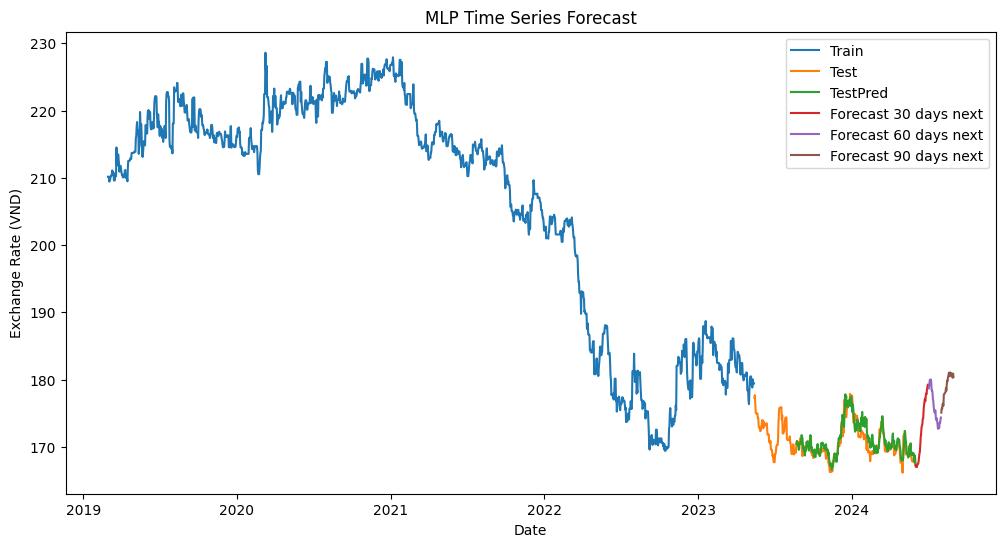

RMSE = 1.2000073812863368
MAPE(%) = 0.5481129936461541
MAE = 0.9351076518313992


In [20]:
implement_MLP(train_jpy_2_sc, test_jpy_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[0.00481975]
101
1 day input [0.05156951 0.05156951 0.05685458 0.05477258 0.04580397 0.06534273
 0.04868674 0.04868674 0.04868674 0.05893658 0.05893658 0.07110826
 0.10313901 0.10185778 0.10185778 0.10185778 0.12139654 0.10938501
 0.10345932 0.10474055 0.0941704  0.0941704  0.0941704  0.08392056
 0.06646381 0.05188981 0.05813581 0.05028828 0.05028828 0.05028828
 0.04996797 0.05285074 0.05076874 0.05092889 0.05621397 0.05621397
 0.05621397 0.05445227 0.06262012 0.06726457 0.06566304 0.07110826
 0.07110826 0.07110826 0.06165919 0.06165919 0.06149904 0.04115951
 0.04452274 0.04452274 0.04452274 0.05301089 0.05172966 0.06518258
 0.06806534 0.06790519 0.06790519 0.06790519 0.06454196 0.06181935
 0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470

8 day output [[0.02204105]]
9 day input [0.04868674 0.05893658 0.05893658 0.07110826 0.10313901 0.10185778
 0.10185778 0.10185778 0.12139654 0.10938501 0.10345932 0.10474055
 0.0941704  0.0941704  0.0941704  0.08392056 0.06646381 0.05188981
 0.05813581 0.05028828 0.05028828 0.05028828 0.04996797 0.05285074
 0.05076874 0.05092889 0.05621397 0.05621397 0.05621397 0.05445227
 0.06262012 0.06726457 0.06566304 0.07110826 0.07110826 0.07110826
 0.06165919 0.06165919 0.06149904 0.04115951 0.04452274 0.04452274
 0.04452274 0.05301089 0.05172966 0.06518258 0.06806534 0.06790519
 0.06790519 0.06790519 0.06454196 0.06181935 0.0578155  0.03971813
 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645 0.
 0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.026105

17 day output [[-0.00156123]]
18 day input [ 0.10938501  0.10345932  0.10474055  0.0941704   0.0941704   0.0941704
  0.08392056  0.06646381  0.05188981  0.05813581  0.05028828  0.05028828
  0.05028828  0.04996797  0.05285074  0.05076874  0.05092889  0.05621397
  0.05621397  0.05621397  0.05445227  0.06262012  0.06726457  0.06566304
  0.07110826  0.07110826  0.07110826  0.06165919  0.06165919  0.06149904
  0.04115951  0.04452274  0.04452274  0.04452274  0.05301089  0.05172966
  0.06518258  0.06806534  0.06790519  0.06790519  0.06790519  0.06454196
  0.06181935  0.0578155   0.03971813  0.02370275  0.02370275  0.02370275
  0.03539398  0.01713645  0.          0.05188981  0.08728379  0.09096733
  0.09096733  0.07399103  0.06278027  0.05076874  0.04324151  0.04596413
  0.04596413  0.04596413  0.04436259  0.03587444  0.04228059  0.06374119
  0.0470852   0.0470852   0.0470852   0.04788597  0.04003844  0.03619475
  0.0318706   0.02674568  0.02674568  0.02674568  0.02834721  0.02610506
  0.02466

27 day output [[0.02116374]]
28 day input [ 0.05028828  0.05028828  0.05028828  0.04996797  0.05285074  0.05076874
  0.05092889  0.05621397  0.05621397  0.05621397  0.05445227  0.06262012
  0.06726457  0.06566304  0.07110826  0.07110826  0.07110826  0.06165919
  0.06165919  0.06149904  0.04115951  0.04452274  0.04452274  0.04452274
  0.05301089  0.05172966  0.06518258  0.06806534  0.06790519  0.06790519
  0.06790519  0.06454196  0.06181935  0.0578155   0.03971813  0.02370275
  0.02370275  0.02370275  0.03539398  0.01713645  0.          0.05188981
  0.08728379  0.09096733  0.09096733  0.07399103  0.06278027  0.05076874
  0.04324151  0.04596413  0.04596413  0.04596413  0.04436259  0.03587444
  0.04228059  0.06374119  0.0470852   0.0470852   0.0470852   0.04788597
  0.04003844  0.03619475  0.0318706   0.02674568  0.02674568  0.02674568
  0.02834721  0.02610506  0.02466368  0.02722614  0.02017937  0.02017937
  0.00481975  0.01252319  0.00692317  0.00091042  0.01166796  0.00727956
  0.00829

37 day output [[0.05799102]]
38 day input [ 0.05445227  0.06262012  0.06726457  0.06566304  0.07110826  0.07110826
  0.07110826  0.06165919  0.06165919  0.06149904  0.04115951  0.04452274
  0.04452274  0.04452274  0.05301089  0.05172966  0.06518258  0.06806534
  0.06790519  0.06790519  0.06790519  0.06454196  0.06181935  0.0578155
  0.03971813  0.02370275  0.02370275  0.02370275  0.03539398  0.01713645
  0.          0.05188981  0.08728379  0.09096733  0.09096733  0.07399103
  0.06278027  0.05076874  0.04324151  0.04596413  0.04596413  0.04596413
  0.04436259  0.03587444  0.04228059  0.06374119  0.0470852   0.0470852
  0.0470852   0.04788597  0.04003844  0.03619475  0.0318706   0.02674568
  0.02674568  0.02674568  0.02834721  0.02610506  0.02466368  0.02722614
  0.02017937  0.02017937  0.00481975  0.01252319  0.00692317  0.00091042
  0.01166796  0.00727956  0.00829695  0.01707951  0.02204105  0.01466002
  0.01335398  0.02460907  0.02413042  0.02528564  0.0180549   0.01540448
  0.0168023

45 day output [[0.09683014]]
46 day input [ 0.06165919  0.06149904  0.04115951  0.04452274  0.04452274  0.04452274
  0.05301089  0.05172966  0.06518258  0.06806534  0.06790519  0.06790519
  0.06790519  0.06454196  0.06181935  0.0578155   0.03971813  0.02370275
  0.02370275  0.02370275  0.03539398  0.01713645  0.          0.05188981
  0.08728379  0.09096733  0.09096733  0.07399103  0.06278027  0.05076874
  0.04324151  0.04596413  0.04596413  0.04596413  0.04436259  0.03587444
  0.04228059  0.06374119  0.0470852   0.0470852   0.0470852   0.04788597
  0.04003844  0.03619475  0.0318706   0.02674568  0.02674568  0.02674568
  0.02834721  0.02610506  0.02466368  0.02722614  0.02017937  0.02017937
  0.00481975  0.01252319  0.00692317  0.00091042  0.01166796  0.00727956
  0.00829695  0.01707951  0.02204105  0.01466002  0.01335398  0.02460907
  0.02413042  0.02528564  0.0180549   0.01540448  0.01680234 -0.00156123
 -0.01215595 -0.00998376  0.00502022  0.01155503  0.0190203   0.03623084
  0.03247

53 day output [[0.13589133]]
54 day input [ 0.06518258  0.06806534  0.06790519  0.06790519  0.06790519  0.06454196
  0.06181935  0.0578155   0.03971813  0.02370275  0.02370275  0.02370275
  0.03539398  0.01713645  0.          0.05188981  0.08728379  0.09096733
  0.09096733  0.07399103  0.06278027  0.05076874  0.04324151  0.04596413
  0.04596413  0.04596413  0.04436259  0.03587444  0.04228059  0.06374119
  0.0470852   0.0470852   0.0470852   0.04788597  0.04003844  0.03619475
  0.0318706   0.02674568  0.02674568  0.02674568  0.02834721  0.02610506
  0.02466368  0.02722614  0.02017937  0.02017937  0.00481975  0.01252319
  0.00692317  0.00091042  0.01166796  0.00727956  0.00829695  0.01707951
  0.02204105  0.01466002  0.01335398  0.02460907  0.02413042  0.02528564
  0.0180549   0.01540448  0.01680234 -0.00156123 -0.01215595 -0.00998376
  0.00502022  0.01155503  0.0190203   0.03623084  0.03247246  0.02490968
  0.02486853  0.02116374  0.0318048   0.03320943  0.03159193  0.04170745
  0.04605

63 day output [[0.22317211]]
64 day input [ 0.02370275  0.02370275  0.03539398  0.01713645  0.          0.05188981
  0.08728379  0.09096733  0.09096733  0.07399103  0.06278027  0.05076874
  0.04324151  0.04596413  0.04596413  0.04596413  0.04436259  0.03587444
  0.04228059  0.06374119  0.0470852   0.0470852   0.0470852   0.04788597
  0.04003844  0.03619475  0.0318706   0.02674568  0.02674568  0.02674568
  0.02834721  0.02610506  0.02466368  0.02722614  0.02017937  0.02017937
  0.00481975  0.01252319  0.00692317  0.00091042  0.01166796  0.00727956
  0.00829695  0.01707951  0.02204105  0.01466002  0.01335398  0.02460907
  0.02413042  0.02528564  0.0180549   0.01540448  0.01680234 -0.00156123
 -0.01215595 -0.00998376  0.00502022  0.01155503  0.0190203   0.03623084
  0.03247246  0.02490968  0.02486853  0.02116374  0.0318048   0.03320943
  0.03159193  0.04170745  0.04605281  0.05358569  0.05895886  0.05409955
  0.05947177  0.05799102  0.0622867   0.07439034  0.07714351  0.07377156
  0.07347

73 day output [[0.20907484]]
74 day input [ 0.06278027  0.05076874  0.04324151  0.04596413  0.04596413  0.04596413
  0.04436259  0.03587444  0.04228059  0.06374119  0.0470852   0.0470852
  0.0470852   0.04788597  0.04003844  0.03619475  0.0318706   0.02674568
  0.02674568  0.02674568  0.02834721  0.02610506  0.02466368  0.02722614
  0.02017937  0.02017937  0.00481975  0.01252319  0.00692317  0.00091042
  0.01166796  0.00727956  0.00829695  0.01707951  0.02204105  0.01466002
  0.01335398  0.02460907  0.02413042  0.02528564  0.0180549   0.01540448
  0.01680234 -0.00156123 -0.01215595 -0.00998376  0.00502022  0.01155503
  0.0190203   0.03623084  0.03247246  0.02490968  0.02486853  0.02116374
  0.0318048   0.03320943  0.03159193  0.04170745  0.04605281  0.05358569
  0.05895886  0.05409955  0.05947177  0.05799102  0.0622867   0.07439034
  0.07714351  0.07377156  0.07347279  0.07442048  0.08348358  0.09683014
  0.10304307  0.1252671   0.14685021  0.14069904  0.13138679  0.12546241
  0.122997

83 day output [[0.17644797]]
84 day input [ 0.0470852   0.0470852   0.0470852   0.04788597  0.04003844  0.03619475
  0.0318706   0.02674568  0.02674568  0.02674568  0.02834721  0.02610506
  0.02466368  0.02722614  0.02017937  0.02017937  0.00481975  0.01252319
  0.00692317  0.00091042  0.01166796  0.00727956  0.00829695  0.01707951
  0.02204105  0.01466002  0.01335398  0.02460907  0.02413042  0.02528564
  0.0180549   0.01540448  0.01680234 -0.00156123 -0.01215595 -0.00998376
  0.00502022  0.01155503  0.0190203   0.03623084  0.03247246  0.02490968
  0.02486853  0.02116374  0.0318048   0.03320943  0.03159193  0.04170745
  0.04605281  0.05358569  0.05895886  0.05409955  0.05947177  0.05799102
  0.0622867   0.07439034  0.07714351  0.07377156  0.07347279  0.07442048
  0.08348358  0.09683014  0.10304307  0.1252671   0.14685021  0.14069904
  0.13138679  0.12546241  0.12299742  0.13589133  0.15092091  0.15470268
  0.15790288  0.17225899  0.18769382  0.19689097  0.20475312  0.20900017
  0.21302

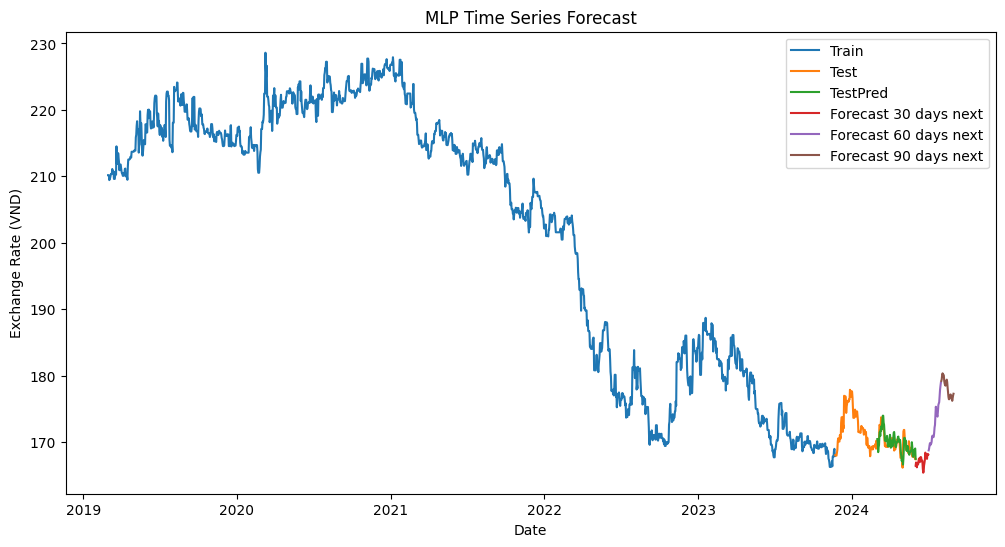

RMSE = 1.1613461889569445
MAPE(%) = 0.5362470909399439
MAE = 0.9111612535559622


In [21]:
implement_MLP(train_jpy_3_sc, test_jpy_3_sc)